In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import MaxPooling2D, Conv2D, Dropout, Flatten, Dense
from imgaug import augmenters as iaa
import cv2
import random
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
np.random.seed(42)

In [4]:
!pwd

/content


In [5]:
!ls

adc.json  carnd  carnd.zip  sample_data


In [6]:
dir_path = "carnd"
cols = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv(dir_path + "/driving_log.csv", names=cols, )
pd.set_option('display.max_colwidth', -1)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/vikramiyer/Desktop/carnd/IMG/center_2018_12_10_11_33_43_083.jpg,/Users/vikramiyer/Desktop/carnd/IMG/left_2018_12_10_11_33_43_083.jpg,/Users/vikramiyer/Desktop/carnd/IMG/right_2018_12_10_11_33_43_083.jpg,0.0,0.0,0,25.10953
1,/Users/vikramiyer/Desktop/carnd/IMG/center_2018_12_10_11_33_43_156.jpg,/Users/vikramiyer/Desktop/carnd/IMG/left_2018_12_10_11_33_43_156.jpg,/Users/vikramiyer/Desktop/carnd/IMG/right_2018_12_10_11_33_43_156.jpg,0.0,0.0,0,24.90617
2,/Users/vikramiyer/Desktop/carnd/IMG/center_2018_12_10_11_33_43_223.jpg,/Users/vikramiyer/Desktop/carnd/IMG/left_2018_12_10_11_33_43_223.jpg,/Users/vikramiyer/Desktop/carnd/IMG/right_2018_12_10_11_33_43_223.jpg,0.0,0.0,0,24.75472
3,/Users/vikramiyer/Desktop/carnd/IMG/center_2018_12_10_11_33_43_295.jpg,/Users/vikramiyer/Desktop/carnd/IMG/left_2018_12_10_11_33_43_295.jpg,/Users/vikramiyer/Desktop/carnd/IMG/right_2018_12_10_11_33_43_295.jpg,0.0,0.0,0,24.55421
4,/Users/vikramiyer/Desktop/carnd/IMG/center_2018_12_10_11_33_43_363.jpg,/Users/vikramiyer/Desktop/carnd/IMG/left_2018_12_10_11_33_43_363.jpg,/Users/vikramiyer/Desktop/carnd/IMG/right_2018_12_10_11_33_43_363.jpg,0.0,0.0,0,24.40489


In [0]:
def get_correct_file_path(x):
  return x.split('/')[-1]

In [0]:
df['center'] = df['center'].apply(get_correct_file_path)
df['right'] = df['right'].apply(get_correct_file_path)
df['left'] = df['left'].apply(get_correct_file_path)

In [0]:
total_bins = 21
hist, bins = np.histogram(df['steering'], total_bins)

In [0]:
center = (bins[:-1] + bins[1:]) * 0.5

<Container object of 21 artists>

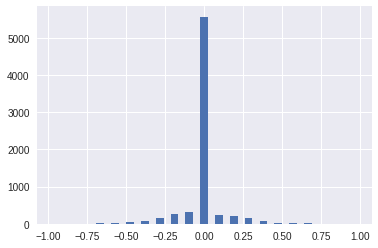

In [12]:
plt.bar(center, hist, width=0.05)

In [13]:
bin_threshold = 200
remove_ixs = []
for i in range(total_bins):
  temp_list = []
  for j in range(df.steering.size):
    if df['steering'][j] >= bins[i] and df['steering'][j] <= bins[i+1]:
      temp_list.append(j)
  # ensure that data is dropped randomly rather than a specific portion of the recording
  temp_list = shuffle(temp_list)
  temp_list = temp_list[bin_threshold:]
  remove_ixs.extend(temp_list)
print("Before: ", df.size)
df.drop(df.index[remove_ixs], inplace=True)
print("After: ", df.size)

Before:  50582
After:  11494


<Container object of 21 artists>

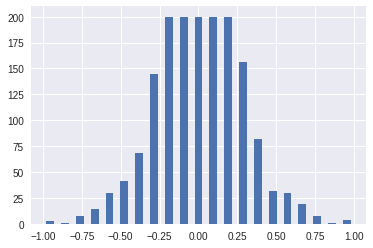

In [14]:
hist, _ = np.histogram(df['steering'], total_bins)
plt.bar(center, hist, width=0.05)

In [0]:
imgdir = 'carnd/IMG/'
def load_data(df):
  path = []
  measurement = []
  for i in range(len(df)):
    ixs = df.iloc[i]
    center, left, right = ixs[0], ixs[1], ixs[2]
    path.append(imgdir + center.strip())
#     path.append(imgdir + left.strip())
#     path.append(imgdir + right.strip())
    measurement.append(float(ixs[3]))
  paths = np.asarray(path)
  measurements = np.asarray(measurement)
  return paths, measurements

paths, measurements = load_data(df)

In [16]:
paths.shape, measurements.shape

((1642,), (1642,))

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(paths, measurements, test_size=0.2, random_state=42)

In [18]:
X_train.shape, X_valid.shape

((1313,), (329,))

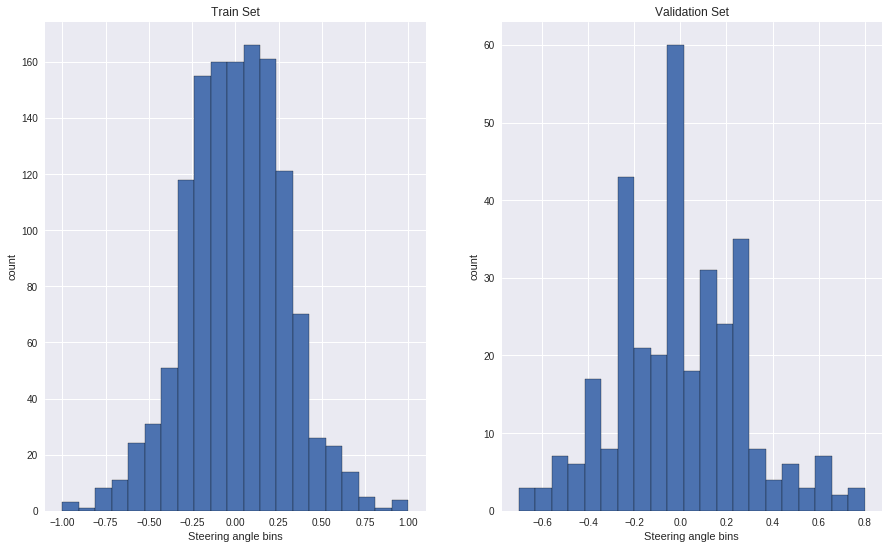

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.hist(y_train, bins=total_bins, edgecolor='black');
ax1.set_title("Train Set");
ax1.set_ylabel("count");
ax1.set_xlabel("Steering angle bins");
ax2.hist(y_valid, bins=total_bins, edgecolor='black');
ax2.set_title("Validation Set");
ax2.set_ylabel("count");
ax2.set_xlabel("Steering angle bins");

In [0]:
def zoom(img):
  zoomed = iaa.Affine(scale=(1,1.3))
  return zoomed.augment_image(img)

def pan(img):
  panned = iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y': (-0.1,0.1)})
  return panned.augment_image(img)

def alter_brightness(img):
  b = iaa.Multiply((0.2, 1.2))
  return b.augment_image(img)

def flip_image(img, steering_ang):
  img = cv2.flip(img, 1)
  return img, -steering_ang

def augment_data(img, ang):
  if np.random.rand() < 0.5:
    img = zoom(img)
  if np.random.rand() < 0.5:
    img = pan(img)
  if np.random.rand() < 0.5:
    img = alter_brightness(img)
  if np.random.rand() < 0.5:
    img = flip_image(img)
  return img, ang

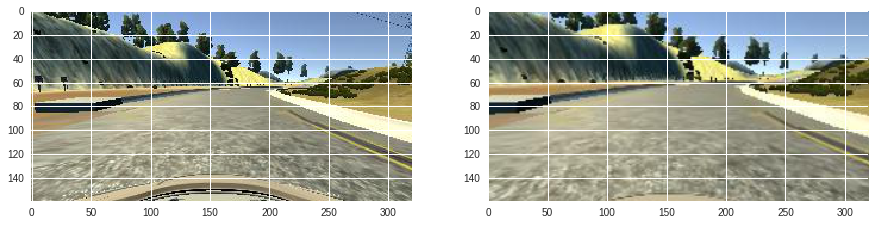

In [21]:
img_path = paths[925]
orig_img = mpimg.imread(img_path)
zoomed_img = zoom(orig_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax2.imshow(zoomed_img);

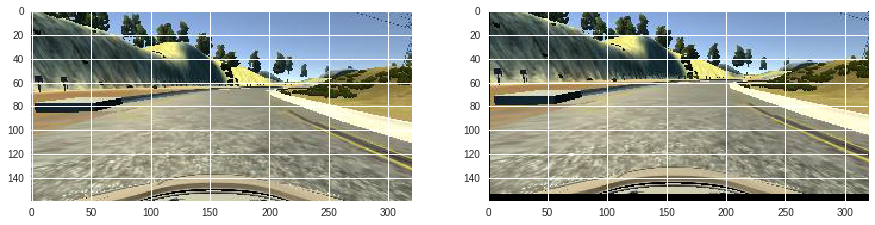

In [22]:
img_path = paths[925]
orig_img = mpimg.imread(img_path)
panned_img = pan(orig_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax2.imshow(panned_img);

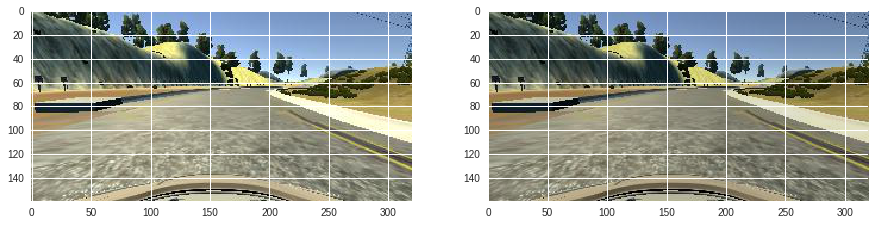

In [23]:
img_path = paths[925]
orig_img = mpimg.imread(img_path)
brightness_altered_img = alter_brightness(orig_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax2.imshow(brightness_altered_img);

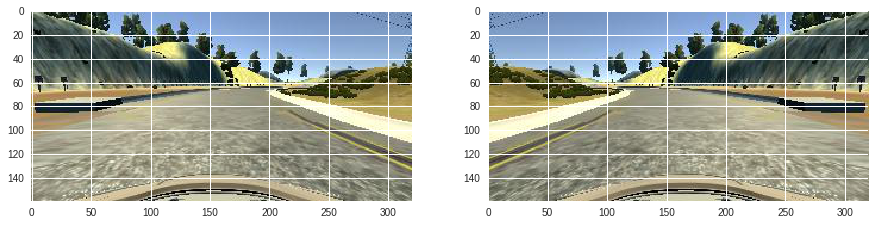

In [24]:
img_path = paths[925]
ang = measurements[925]
orig_img = mpimg.imread(img_path)
flipped_img, flipped_ang = flip_image(orig_img, ang)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax2.imshow(flipped_img);

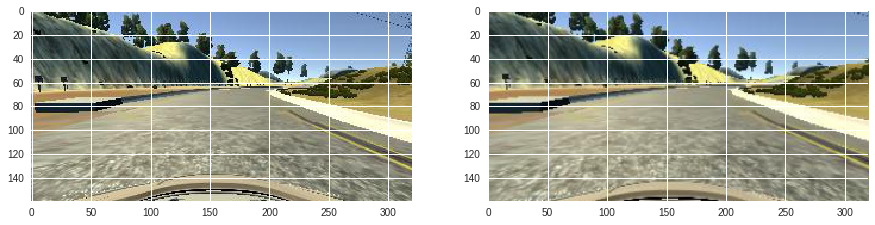

In [25]:
img_path = paths[925]
orig_img = mpimg.imread(img_path)
zoomed_img = zoom(orig_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax2.imshow(zoomed_img);

In [0]:
def preprocess(img_path):
  # convert to YUV space as Nvidia Model we will use has used the same space
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2YUV)
  # slice the unwanted sections from the image
  img = img[60:135,:,:]
  # smooth the image using a gaussian kernel: denoise
  img = cv2.GaussianBlur(img, (3, 3), 0)
  # reshape to fit the input size of Nvidia Model
  img = cv2.resize(img, (200, 66))
  # normalize
  img = img/255
  return img


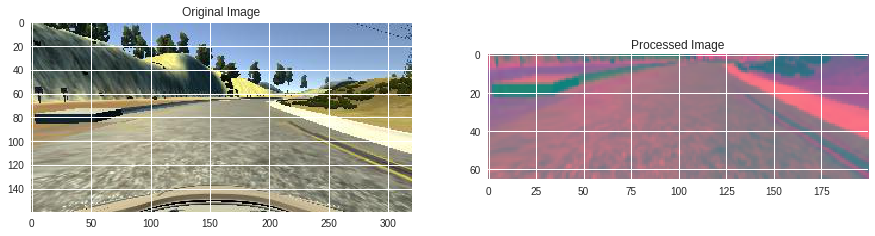

In [27]:
# random_number = np.random.randint(len(X_train)-1)
random_number = 925
img = paths[random_number]
orig_img = mpimg.imread(img)
processed_img = preprocess(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,9))
ax1.imshow(orig_img);
ax1.set_title("Original Image");
ax2.imshow(processed_img);
ax2.set_title("Processed Image");

In [0]:
X_train = np.array(list(map(preprocess, X_train)))
X_valid = np.array(list(map(preprocess, X_valid)))

In [29]:
X_train.shape, X_valid.shape

((1313, 66, 200, 3), (329, 66, 200, 3))

In [0]:
#Model
def NvidiaModel():
  
  # defining our model
  model = Sequential()
  
  # 1 conv2D layer=> input: 66x200x3, total_params: 5x5x24x3+24=1824
  model.add(Conv2D(24, (5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='relu'))
  
  # 2 conv2D layer=> input: 31x98x24, total_params: 5x5x36x24+36=21636
  model.add(Conv2D(36, (5, 5), strides=(2,2), activation='relu'))
  
  # 3 conv2D layer=> input: 14x47x36, total_params: 5x5x48x36+48=43248
  model.add(Conv2D(48, (5, 5), strides=(2,2), activation='relu'))
  
  # 4 conv2D layer=> input: 5x22x48, total_params=3x3x64x48+64=27712
  model.add(Conv2D(64, (3, 3), activation='relu'))
  
  # 5 conv2D layer=> input: 3x20x64, total_params: 3x3x64x64+64=36928, output_shape=(1x18x64)
  model.add(Conv2D(64, (3, 3), activation='relu'))
  
  # Dropout=> total_params=0, output_shape=1x18x64
  model.add(Dropout(0.5))
  
  # Flatten=> total_params=0, output_shape: 1152
  model.add(Flatten())
  
  # Dense=> output_shape=100, total_params=1152x100+100=115300
  model.add(Dense(100, activation='relu'))
  
  # Dropout=> total_params=0, output_shape=100
  model.add(Dropout(0.5))
  
  # Dense=> total_params=100x50+50=5050
  model.add(Dense(50, activation='relu'))
  
  # Dense=> total_params=50x10+10=510
  model.add(Dense(10, activation='relu'))
  
  # Dense=> total_params=10x1+1=11
  model.add(Dense(1))
  
  # compile
  optimizer=Adam(lr=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
model = NvidiaModel()

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [33]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size=64, shuffle=1)

Train on 1313 samples, validate on 329 samples
Epoch 1/15
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0797 - val_loss: 0.0755
Epoch 2/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0780 - val_loss: 0.0754
Epoch 3/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0776 - val_loss: 0.0741
Epoch 4/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0744 - val_loss: 0.0635
Epoch 5/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0606 - val_loss: 0.0393
Epoch 6/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0462 - val_loss: 0.0339
Epoch 7/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0405 - val_loss: 0.0298
Epoch 8/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0382 - val_loss: 0.0292
Epoch 9/15
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0354 - val_loss: 0.0300
Epoch 10/15
1313/1313 [==

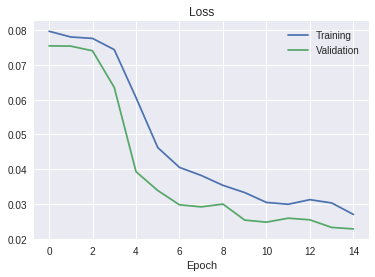

In [34]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['Training','Validation']);
plt.title('Loss');
plt.xlabel('Epoch');

In [0]:
model.save("model.h5")

In [0]:
from google.colab import files
files.download("model.h5")